In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -d -u

Sebastian Raschka 
Last updated: 19/03/2015 


<br>
<br>

# Logistic Regression

hypothesis: $h_{\theta}(x) = g(\theta^T x)$

sigmoid function: $g(z) = \frac{1}{1 + e^{-z}}$

$0 \ge h_{\theta}(x) \le 1$ 

$h_{\theta}(x) = g(\theta^T x) = \frac{1}{1 + e^{-\theta^T x}}$ can be interpreted as the posterior probability. For classification
use step function:  
$h_{\theta}(x) \le 0.5 \rightarrow 0$   
$h_{\theta}(x) > 0.5 \rightarrow 1$ 

$h_{\theta}(x):  \theta_1 x_1 + \dots + \theta_n x_n >  \theta_0$

equivalent to 

$h_{\theta}(x) = -\theta_0 + \theta_1 x_1 + \dots + \theta_n x_n > 0$

Linear Regression Cost function (gradiend descent):
    
$J(\theta) = \frac{1}{2m} \sum (h_{\theta}(x^{(i)}) - y)^2$

Now using  $\frac{1}{1 + e^{-\theta^T x}}$ (not convex anymore)

### Sigmoid

In [3]:
import numpy as np

def sigmoid(z):
    return 1/(1 + np.exp(-z))

assert(sigmoid(0) == 0.5)
assert(sigmoid(10000) == 1.0)
assert(sigmoid(-10000) == 0.0)

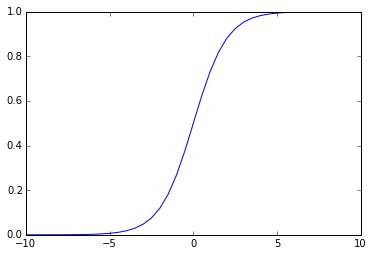

In [4]:
plt.plot(np.arange(-10, 10, 0.5), [sigmoid(z) for z in np.arange(-10, 10, 0.5)])
plt.show()

### Cost Function and Gradient

$J(\theta) = \frac{1}{m} \sum^{m}_{i=1} \big[ -y^{(i)} log(h_{\theta}(x^{(i)})) - (1-y^{(i)})log(1-h_{\theta}(x^{(i)}))  \big]$

$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)}) x^{(i)}_j$

### Update Rule

$\theta_j := \theta_j - \alpha \sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)}) x^{(i)}_j$

## Regularization

$J(\theta) = \frac{1}{m} \sum^{m}_{i=1} \big[ -y^{(i)} \
log(h_{\theta}(x^{(i)})) - \
(1-y^{(i)})log(1-h_{\theta}(x^{(i)}))  \big]\
%regularize\
+ \frac{\lambda}{2m} \sum_{j=1}^{n} \theta^2_j$

Do not regularize $\theta_0$

$\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)}) x^{(i)}_j \
\quad \quad \text{for } j = 0$

$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)}) x^{(i)}_j \
+ \frac{\lambda}{m} \theta_j \
\quad \quad \text{for } j \ge 1$

In [3]:
# Sebastian Raschka 2015
# mlxtend Machine Learning Library Extensions


import numpy as np

class LogisticRegression(object):
    """Logistic regression classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)

    epochs : int
      Passes over the training dataset.

    learning : str (default: sgd)
      Learning rule, sgd (stochastic gradient descent)
      or gd (gradient descent).

    lambda_ : float
      Regularization parameter for L2 regularization.
      No regularization if lambda_=0.0.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.

    cost_ : list
      List of floats with sum of squared error cost (sgd or gd) for every
      epoch.

    """
    def __init__(self, eta=0.01, epochs=50, lambda_=0.0, learning='sgd'):
        self.eta = eta
        self.epochs = epochs
        self.lambda_ = lambda_

        if not learning in ('sgd', 'gd'):
            raise ValueError('learning must be sgd or gd')
        self.learning = learning


    def fit(self, X, y, init_weights=None):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        y : array-like, shape = [n_samples]
            Target values.

        init_weights : array-like, shape = [n_features + 1]
            Initial weights for the classifier. If None, weights
            are initialized to 0.

        Returns
        -------
        self : object

        """
        if not len(X.shape) == 2:
            raise ValueError('X must be a 2D array. Try X[:,np.newaxis]')

        if (np.unique(y) != np.array([0, 1])).all():
            raise ValueError('Supports only binary class labels 0 and 1')

        if not isinstance(init_weights, np.ndarray):
        # Initialize weights to 0
            self.w_ = np.zeros(1 + X.shape[1])
        else:
            self.w_ = init_weights

        self.cost_ = []

        for i in range(self.epochs):

            if self.learning == 'gd':
                y_val = self.activation(X)
                errors = (y - y_val)
                regularize = self.lambda_ * self.w_[1:]
                self.w_[1:] += self.eta * X.T.dot(errors)
                self.w_[1:] += regularize
                self.w_[0] += self.eta * errors.sum()

            elif self.learning == 'sgd':
                cost = 0.0
                for xi, yi in zip(X, y):
                    yi_val = self.activation(xi)
                    error = (yi - yi_val)
                    regularize = self.lambda_ * self.w_[1:]
                    self.w_[1:] += self.eta * xi.dot(error)
                    self.w_[1:] += regularize
                    self.w_[0] += self.eta * error

            self.cost_.append(self._logit_cost(y, self.activation(X)))
        return self


    def predict(self, X):
        """
        Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        class : int
          Predicted class label.

        """
        # equivalent to np.where(self.activation(X) >= 0.5, 1, 0)
        return np.where(self.net_input(X) >= 0.0, 1, 0)


    def net_input(self, X):
        """ Net input function. """
        return X.dot(self.w_[1:]) + self.w_[0]


    def activation(self, X):
        """
        Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        int
          Class probability.

        """
        z = self.net_input(X)
        return self._sigmoid(z)


    def _logit_cost(self, y, y_val):
        logit = -y.dot(np.log(y_val)) - ((1 - y).dot(np.log(1 - y_val)))
        regularize = (self.lambda_ / 2) * self.w_[1:].dot(self.w_[1:])
        return logit + regularize


    def _sigmoid(self, z):
         return 1.0 / (1.0 + np.exp(-z))

## Iris example

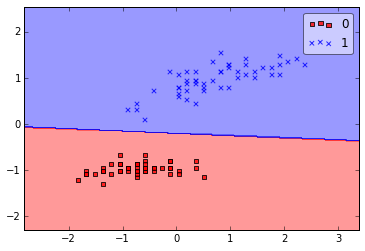

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import pandas as pd
import numpy as np

sys.path = ['/Users/sebastian/github/mlxtend/'] + sys.path
from mlxtend.evaluate import plot_decision_regions


df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

# setosa and versicolor
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 0, 1)

# sepal length and petal length
X = df.iloc[0:100, [0,2]].values

# standardize features
X_std = np.copy(X)
X_std[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X_std[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

lr = LogisticRegression(eta=0.1, epochs=100)
lr.fit(X_std, y)

plot_decision_regions(X_std, y, clf=lr, res=0.02)

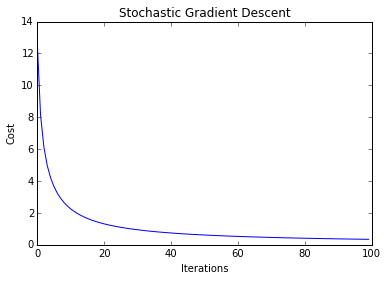

In [7]:
plt.plot(range(len(lr.cost_)), lr.cost_)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Stochastic Gradient Descent')
#plt.text(40, 45, 'eta = 0.01')
plt.show()